# Controllers
Several model predictive controllers are available in `sia`, depending on which type of model and cost are being used.  For Linear/Gaussian models with quadratic costs, the `sia.LQR` linear quadratic regulator is optimal and the most efficient.  For Nonlinear/Gaussian with a differentiable cost, the `sia.iLQR` controller should be used.  Nonlinear/Gaussian with a general cost, `sia.MPPI` should be used.

| Controller | Optimal  | Supported costs                                 | Supported models                  |
| ---------- | -------- | ----------------------------------------------- |---------------------------------- |
| LQR        | Yes      | QuadraticCost                                   | LinearGaussian                    |
| iLQR       | No       | DifferentiableCost, QuadraticCost               | NonlinearGaussian, LinearGaussian |
| MPPI       | No       | CostFunction, DifferentiableCost, QuadraticCost | NonlinearGaussian, LinearGaussian |

This example compares these algorithms to control a linear/Gaussian model with a quadratic, since they are the most widely supported model and cost types.  In practice, `sia.LQR` should be used for this problem class.

In [1]:
# Import the libSIA python bindings and numpy
import pysia as sia
import numpy as np

# Import plotting helpers
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

We'll use a simple second order linear system with a saddle point.  The controller tries to drive the system to $x_d = (0, 0)$.  The input $u$ linearly maps to both states which makes the system controllable.
$$
\dot{x} = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix} x
 + \begin{pmatrix} 1 \\ 10 \end{pmatrix} u
$$

We'll also define a quadratic cost function
$$
J(x, u) = x_N^\top \begin{pmatrix} 10 & 0 \\ 0 & 10 \end{pmatrix} x_N + \sum_{i=1}^{N-1} x_i^\top \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix} x_i + \frac{u_i^2}{10}
$$

In [2]:
# System
dt = 0.01
A = np.array([[0, 10], [1, 0]])
B = np.array([[1], [10]])
I = np.eye(2)

system = sia.LinearGaussianCT(A, B, I, I, I, I, dt)

# Cost
Qf = np.diag([10, 20])
Q = np.diag([2, 4])
R = np.diag([1])

cost = sia.QuadraticCost(Qf, Q, R)

We initialize the controllers around the linear system.  The nonlinear estimators must be initialized with a control history, which we will choose to be zero for a fixed horizon since we're not sure what a good initialization will be.  The horizon is also quite impactful to the controller performance, typically chosen based by the time constant of the system dynamics.  Note that the controllers use the previous control history as starting point for the next policy call, so if they coverge toward a decent solution they will begin to perform local corrections to improve the previous control.

In [3]:
# Define the initial control and time horizon
horizon = 3
u0 = [np.array([0]) for i in range(horizon)]

# Initialize LQR, iLQR, and MPPI
lqr = sia.LQR(system, cost, horizon)
ilqr = sia.iLQR(system, cost, u0, max_iter=10, max_backsteps=10)
mppi = sia.MPPI(system, cost, u0, num_samples=1000, sigma=np.diag([1.0]), lam=1e-1)

Now let's simulate each controller from the same initial state

In [4]:
# Initialize the runner with a buffer for n_steps
n_steps = 100
controllers = {"lqr": lqr, "ilqr": ilqr, "mppi": mppi}

# Initialize the ground truth state and step/estimate for n_steps
x0 = np.array([1, 1])
x_lqr = np.zeros((2, n_steps))
u_lqr = np.zeros((1, n_steps))
x_ilqr = np.zeros((2, n_steps))
u_ilqr = np.zeros((1, n_steps))
x_mppi = np.zeros((2, n_steps))
u_mppi = np.zeros((1, n_steps))
x_lqr[:,0] = x0
x_ilqr[:,0] = x0
x_mppi[:,0] = x0
s = sia.Gaussian(2)
for k in range(0, n_steps-1):
    s.setMean(x_lqr[:,k])
    u_lqr[:,k] = lqr.policy(s)
    x_lqr[:,k+1] = system.f(x_lqr[:,k], u_lqr[:,k])
    
    s.setMean(x_ilqr[:,k])
    u_ilqr[:,k] = ilqr.policy(s)
    x_ilqr[:,k+1] = system.f(x_ilqr[:,k], u_ilqr[:,k])
    
    s.setMean(x_mppi[:,k])
    u_mppi[:,k] = mppi.policy(s)
    x_mppi[:,k+1] = system.f(x_mppi[:,k], u_mppi[:,k])

Now let's plot the resulting trajectories and see how the controllers fared with this problem

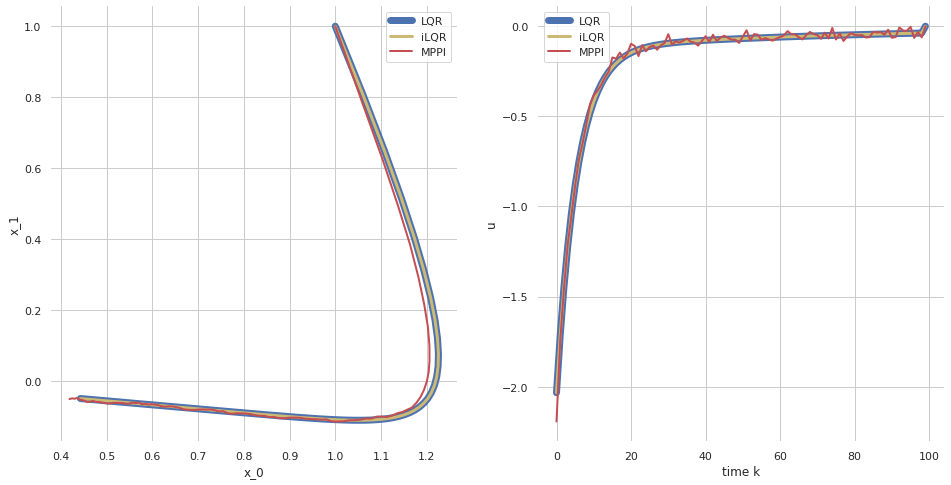

In [5]:
# Plot the recorded states
f, ax = plt.subplots(1, 2, figsize=(16, 8))
sns.despine(f, left=True, bottom=True)

# Show the state phase plane
ax[0].plot(x_lqr[0, :], x_lqr[1, :], '-b', label="LQR", lw=7)
ax[0].plot(x_ilqr[0, :], x_ilqr[1, :], '-y', label="iLQR", lw=3)
ax[0].plot(x_mppi[0, :], x_mppi[1, :], '-r', label="MPPI", lw=2)
ax[0].legend()
ax[0].set_xlabel("x_0")
ax[0].set_ylabel("x_1")

# Show the control over time
ax[1].plot(u_lqr[0, :], '-b', label="LQR", lw=7)
ax[1].plot(u_ilqr[0, :], '-y', label="iLQR", lw=3)
ax[1].plot(u_mppi[0, :], '-r', label="MPPI", lw=2)
ax[1].legend()
ax[1].set_xlabel("time k")
ax[1].set_ylabel("u")

plt.show()